# Lectura de los datos limpios

In [192]:
# Importar librerías
import pandas
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

In [193]:
data = pandas.read_csv("./IMDb_Limpio.csv")

In [194]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6616 entries, 0 to 6615
Columns: 928 entries, Unnamed: 0 to dia_semana_6
dtypes: bool(486), float64(8), int64(425), object(9)
memory usage: 25.4+ MB


In [195]:
data.head()

,Unnamed: 0,imdb_title_id,title,original_title,year,date_published,genre,duration,country,language,...,mes_10,mes_11,mes_12,dia_semana_0,dia_semana_1,dia_semana_2,dia_semana_3,dia_semana_4,dia_semana_5,dia_semana_6
0,506,tt0017136,Metropolis,Metropolis,0,1928-10-01,"Drama, Sci-Fi",153,Germany,German,...,1,0,0,1,0,0,0,0,0,0
1,1048,tt0021749,Luci della città,City Lights,1,1931-04-02,"Comedy, Drama, Romance",87,USA,English,...,0,0,0,0,0,0,1,0,0,0
2,2454,tt0027977,Tempi moderni,Modern Times,2,1937-03-12,"Comedy, Drama, Family",87,USA,English,...,0,0,0,0,0,0,0,1,0,0
3,2795,tt0029453,Il bandito della Casbah,Pépé le Moko,3,1937-10-22,"Crime, Drama, Romance",94,France,"French, Arabic",...,1,0,0,0,0,0,0,1,0,0
4,2827,tt0029583,Biancaneve e i sette nani,Snow White and the Seven Dwarfs,3,1938-11-30,"Animation, Family, Fantasy",83,USA,English,...,0,1,0,0,0,1,0,0,0,0


# Variables que se usan para el split de los datos

In [196]:
# Limpieza de Género. Hace dummies para cada género distinto. 
generos = []
for j in data['genre'].dropna().str.rsplit(', '):
    for i in j:
        if i not in generos:
            generos.append(i)

generos_names = ["{}{}".format(i,"_Genre") for i in generos]

lenguaje = []
for j in data['language'].dropna().str.rsplit(', '):
    for i in j:
        if i not in lenguaje:
            lenguaje.append(i)

lenguaje_names = ["{}{}".format(i,"_Language") for i in lenguaje]

pais = []
for j in data['country'].dropna().str.rsplit(', '):
    for i in j:
        if i not in pais:
            pais.append(i)

pais_names = ["{}{}".format(i,"_Country") for i in pais]

In [197]:
director_list = [s for s in list(data.columns) if "director" in s]
writer_list = [s for s in list(data.columns) if "writer" in s]
prodcomp_list = [s for s in list(data.columns) if "production" in s]
mes_list = [s for s in list(data.columns) if "mes" in s]
dia_semana_list = [s for s in list(data.columns) if "dia_semana" in s]

# Separacion en training, test y validación 

In [198]:
# Separa la base de datos, usa la variable "quality" como variable objetivo, y
# todas las demás variables como variables explicativas
X = data[["duration", "avg_vote", "votes", \
          "budget","metascore", "reviews_from_users",  \
          "reviews_from_critics" ] + mes_list + dia_semana_list].to_numpy()
x_imp = data[["duration", "avg_vote", "votes", \
          "budget","metascore", "reviews_from_users",  \
          "reviews_from_critics"]+ mes_list + dia_semana_list]
Y = data["gross_income"].to_numpy()

print(X.shape)
print(Y.shape)

(6616, 29)
(6616,)


In [199]:

print(X.shape)
print(Y.shape)

(6616, 29)
(6616,)


In [200]:
# Separamos en training, validación y testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)

print(f"{len(x_train)} training samples")
print(f"{len(x_val)} validation samples")
print(f"{len(x_test)} test samples")

4762 training samples
530 validation samples
1324 test samples


# Setup para modelar

In [201]:
# Metricas
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score
import time

# Modelos
from sklearn.neighbors import KNeighborsRegressor # kNN
from sklearn.tree import DecisionTreeRegressor # Arbol de Decisiones
from sklearn.svm import SVR # Support Vector Regression
from sklearn.linear_model import Lasso # Regresion Regularizada con Lasso
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.neural_network import MLPRegressor # Multi Layer perceptron
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.svm import LinearSVR # Linear Support Vector Regression

# Para poder hacer búsqueda de línea 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

In [202]:
# Set print options for decimal values
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

# Random Forest

In [203]:
# Grid search over Random Forest
parameters = {'n_estimators': [10,20,30, 300]}

gs_model = GridSearchCV(RandomForestRegressor(max_features='sqrt'), parameters, n_jobs=-1, scoring="r2")
start = time.time()
gs_model.fit(x_train, y_train)
stop = time.time()

print(f"Training time: {stop - start}s")
print(f"Best score: {gs_model.best_score_:.3f}")
print(f"Best params: {gs_model.best_params_}")

Training time: 8.106972694396973s
Best score: 0.722
Best params: {'n_estimators': 300}


In [204]:
# Predict on validation data, and print score
y_val_hat = gs_model.best_estimator_.predict(x_val)

print(f"MSE on the training set: {mean_squared_error(gs_model.best_estimator_.predict(x_train), y_train):.3f}")
print(f"MSE on the validation set: {mean_squared_error(gs_model.best_estimator_.predict(x_val), y_val):.3f}")
print(f"MSE on the test set: {mean_squared_error(gs_model.best_estimator_.predict(x_test), y_test):.3f}")
print()
print(f"MAE on the training set: {mean_absolute_error(gs_model.best_estimator_.predict(x_train), y_train):.3f}")
print(f"MAE on the validation set: {mean_absolute_error(gs_model.best_estimator_.predict(x_val), y_val):.3f}")
print(f"MAE on the test set: {mean_absolute_error(gs_model.best_estimator_.predict(x_test), y_test):.3f}")
print()
print(f"MAPE on the training set: {mean_absolute_percentage_error(gs_model.best_estimator_.predict(x_train), y_train):.3f}")
print(f"MAPE on the validation set: {mean_absolute_percentage_error(gs_model.best_estimator_.predict(x_val), y_val):.3f}")
print(f"MAPE on the test set: {mean_absolute_percentage_error(gs_model.best_estimator_.predict(x_test), y_test):.3f}")
print()
print(f"R^2 on the training set: {r2_score(gs_model.best_estimator_.predict(x_train), y_train):.3f}")
print(f"R^2 on the validation set: {r2_score(gs_model.best_estimator_.predict(x_val), y_val):.3f}")
print(f"R^2 on the test set: {r2_score(gs_model.best_estimator_.predict(x_test), y_test):.3f}")

MSE on the training set: 1.000
MSE on the validation set: 8.626
MSE on the test set: 8.060

MAE on the training set: 0.719
MAE on the validation set: 2.081
MAE on the test set: 2.022

MAPE on the training set: 0.025
MAPE on the validation set: 0.069
MAPE on the test set: 0.068

R^2 on the training set: 0.954
R^2 on the validation set: 0.518
R^2 on the test set: 0.576


# Importancia

In [205]:
# test classification dataset
from sklearn.datasets import make_classification
# summarize the dataset
print(X.shape, Y.shape)

(6616, 29) (6616,)


In [206]:
# random forest for feature importance on a classification problem
from sklearn.datasets import make_classification
from matplotlib import pyplot

# get importance
importance = gs_model.best_estimator_.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))


Feature: 0, Score: 0.04682
Feature: 1, Score: 0.04364
Feature: 2, Score: 0.26063
Feature: 3, Score: 0.25294
Feature: 4, Score: 0.04034
Feature: 5, Score: 0.19029
Feature: 6, Score: 0.08932
Feature: 7, Score: 0.00023
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00333
Feature: 11, Score: 0.00324
Feature: 12, Score: 0.00391
Feature: 13, Score: 0.00395
Feature: 14, Score: 0.00428
Feature: 15, Score: 0.00388
Feature: 16, Score: 0.00330
Feature: 17, Score: 0.00362
Feature: 18, Score: 0.00432
Feature: 19, Score: 0.00450
Feature: 20, Score: 0.00367
Feature: 21, Score: 0.00382
Feature: 22, Score: 0.00132
Feature: 23, Score: 0.00167
Feature: 24, Score: 0.00455
Feature: 25, Score: 0.00560
Feature: 26, Score: 0.00984
Feature: 27, Score: 0.00406
Feature: 28, Score: 0.00294


<BarContainer object of 29 artists>

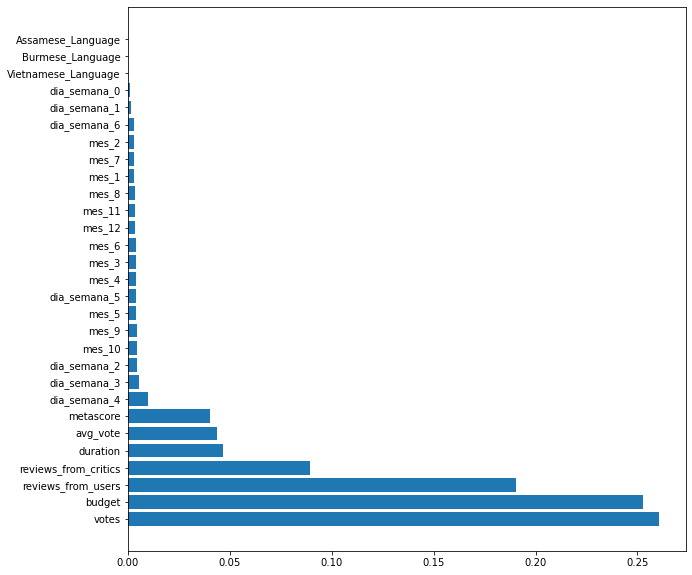

In [211]:
plt.rcParams['figure.figsize'] = [10, 10]
pyplot.barh(aux.feature, aux.importance)